## 0. Setup

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
import subprocess
import shutil

os.chdir('./models/research')

# Kompiliere die Protocol Buffers
subprocess.run(['protoc', 'object_detection/protos/*.proto', '--python_out=.'], shell=True, check=True)

# Kopiere die setup.py Datei
shutil.copy('object_detection/packages/tf2/setup.py', '.')

# Installiere die Object Detection API
subprocess.run(['python', '-m', 'pip', 'install', '.'], shell=True, check=True)

CompletedProcess(args=['python', '-m', 'pip', 'install', '.'], returncode=0)

In [3]:
pip uninstall protobuf

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install protobuf

In [ ]:
!curl https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py > c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\google\protobuf\internal\builder.py

In [4]:
!python object_detection/builders/model_builder_tf2_test.py

python: can't open file 'c:\Users\Alexej\Desktop\GTSRB\object_detection\builders\model_builder_tf2_test.py': [Errno 2] No such file or directory


In [3]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\builders\model_builder_tf2_test.py

^C


In [3]:
pipeline_config = './myModules/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

print("Modell erfolgreich geladen und gebaut.")

Modell erfolgreich geladen und gebaut.


## 1. Start

In [2]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [3]:
#Checking for gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.10.1


In [4]:
#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.compat.v1.random.set_random_seed(42)

## 2. Dataset

In [7]:
train_path = './GTSRB/Final_Training/Images'
test_path = './GTSRB/Final_Test/Images'

In [11]:
def readTrafficSignsTrain(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns: DataFrame containing labels, image shapes, ROIs, and image paths'''
    
    # Initialisiere eine leere Liste für die Daten
    data = []

    # loop over all 43 classes
    for c in range(0, 43):
        prefix = f"{rootpath}/{c:05d}/"  # subdirectory for class
        gtFile = open(prefix + f'GT-{c:05d}.csv')  # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
        next(gtReader)  # skip header

        # loop over all images in current annotations file
        for row in gtReader:
            img_path = prefix + row[0]
            img = plt.imread(img_path)  # load image

            label = int(row[7])  # the 8th column is the label
            height = img.shape[0]  # height of the image
            width = img.shape[1]  # width of the image
            #channels = img.shape[2] if len(img.shape) > 2 else 1  # channels of the image (default to 1 if grayscale)
            roi_x1 = int(row[3])  # ROI X1 coordinate
            roi_y1 = int(row[4])  # ROI Y1 coordinate
            roi_x2 = int(row[5])  # ROI X2 coordinate
            roi_y2 = int(row[6])  # ROI Y2 coordinate

            # Füge die Daten als Zeile hinzu
            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])

        gtFile.close()

    # Erstelle ein DataFrame aus der Liste
    df = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    return df

In [12]:
def readTrafficSignsTest(rootpath):
    '''Reads the final test data for the German Traffic Sign Recognition Benchmark.
    Arguments: path to the final test data, for example './GTSRB/Final_Test/Images'
    Returns: DataFrame with image data, labels, image shapes, and ROI
    '''
    # Pfad zur CSV-Datei
    csv_file = os.path.join(rootpath, 'GT-final_test_gt.csv')
    
    # Lade die CSV-Datei
    df = pd.read_csv(csv_file, delimiter=';')
    
    # Liste zum Speichern der Daten
    data = []
    
    # Schleife über alle Zeilen der CSV-Datei
    for _, row in df.iterrows():
        img_path = os.path.join(rootpath, row['Filename'])
        img = plt.imread(img_path)  # Lade das Bild
        
        if img is not None:
            label = int(row['ClassId'])
            height, width, channels = img.shape
            roi_x1 = int(row['Roi.X1'])
            roi_y1 = int(row['Roi.Y1'])
            roi_x2 = int(row['Roi.X2'])
            roi_y2 = int(row['Roi.Y2'])
            
            # Füge die Daten als Zeile hinzu
            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])
        else:
            print(f"Bild {img_path} konnte nicht geladen werden.")
    
    # Erstelle ein DataFrame aus der Liste
    df_test = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    return df_test

In [13]:
df_train_raw = readTrafficSignsTrain(train_path)
df_test_raw = readTrafficSignsTest(test_path)

In [14]:
df_train_raw.info()
df_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Width   39209 non-null  int64 
 1   Height  39209 non-null  int64 
 2   Roi.X1  39209 non-null  int64 
 3   Roi.Y1  39209 non-null  int64 
 4   Roi.X2  39209 non-null  int64 
 5   Roi.Y2  39209 non-null  int64 
 6   Path    39209 non-null  object
 7   Label   39209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Width   12630 non-null  int64 
 1   Height  12630 non-null  int64 
 2   Roi.X1  12630 non-null  int64 
 3   Roi.Y1  12630 non-null  int64 
 4   Roi.X2  12630 non-null  int64 
 5   Roi.Y2  12630 non-null  int64 
 6   Path    12630 non-null  object
 7   Label   12630 non-null  int64 
dtypes: int64(

In [15]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train = df_train_raw
df_test = df_test_raw

In [16]:
# Ein Bild aus dem DataFrame laden und anzeigen
image = plt.imread(df_train['Path'][0])

plt.imshow(image)
plt.show()

C:\Users\Alexej\AppData\Local\Temp\ipykernel_20196\3489177150.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### 2.1 Tensor records

In [8]:
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image, ImageEnhance

In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

N_CHANNELS = 3
BATCH_SIZE = 32
N_EPOCHS = 50
VAL_BATCH_SIZE = 32
CLASS_NAMES = list(range(43))
N_CLASSES = 43

In [19]:
def create_tf_example(row):
    img_path = row['Path']
    # Lade das Bild und konvertiere es in ein kompatibles Format (z.B. JPEG)
    image = Image.open(img_path)
    image = image.convert("RGB")
    with io.BytesIO() as output:
        image.save(output, format="JPEG")
        encoded_jpg = output.getvalue()

    width, height = image.size

    filename = row['Path'].encode('utf8')
    image_format = b'jpeg'  # Ändere dies entsprechend des konvertierten Bildformats
    xmins = [row['Roi.X1'] / width]
    xmaxs = [row['Roi.X2'] / width]
    ymins = [row['Roi.Y1'] / height]
    ymaxs = [row['Roi.Y2'] / height]
    classes_text = [str(row['Label']).encode('utf8')]
    classes = [int(row['Label'])]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))
    return tf_example

In [20]:
def create_tf_record(df, output_path):
    writer = tf.io.TFRecordWriter(output_path)
    for index, row in df.iterrows():
        tf_example = create_tf_example(row)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [21]:
create_tf_record(df_train, 'train.record')
create_tf_record(df_test, 'test.record')

### 2.2 Verify Tensord records

In [28]:
import matplotlib
matplotlib.use('TkAgg')

C:\Users\Alexej\AppData\Local\Temp\ipykernel_23896\115724347.py:2: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('TkAgg')


In [21]:
def parse_tf_example(serialized_example):
    feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/class/text': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(serialized_example, feature_description)

In [17]:
def read_tfrecord(record_file):
    raw_dataset = tf.data.TFRecordDataset(record_file)
    parsed_dataset = raw_dataset.map(parse_tf_example)
    return parsed_dataset

In [18]:
def display_image_at_index(parsed_dataset, index):
    for i, tf_example in enumerate(parsed_dataset):
        if i == index:
            height = tf_example['image/height'].numpy()
            width = tf_example['image/width'].numpy()
            encoded_image = tf_example['image/encoded'].numpy()
            xmin = tf_example['image/object/bbox/xmin'].numpy()
            xmax = tf_example['image/object/bbox/xmax'].numpy()
            ymin = tf_example['image/object/bbox/ymin'].numpy()
            ymax = tf_example['image/object/bbox/ymax'].numpy()
            label = tf_example['image/object/class/label'].numpy()

            image = tf.image.decode_jpeg(encoded_image)
            image_np = image.numpy()

            plt.figure(figsize=(4, 4))
            plt.imshow(image_np)
            plt.title(f'Label: {label}')

            # Draw the bounding box
            plt.gca().add_patch(plt.Rectangle((xmin * width, ymin * height), 
                                              (xmax - xmin) * width, (ymax - ymin) * height,
                                              edgecolor='green', facecolor='none', linewidth=2))
            plt.axis('off')
            plt.show()
            break

In [19]:
def display_sample_image(parsed_dataset):
    for tf_example in parsed_dataset.take(2):
        height = tf_example['image/height'].numpy()
        width = tf_example['image/width'].numpy()
        encoded_image = tf_example['image/encoded'].numpy()
        xmin = tf_example['image/object/bbox/xmin'].numpy()
        xmax = tf_example['image/object/bbox/xmax'].numpy()
        ymin = tf_example['image/object/bbox/ymin'].numpy()
        ymax = tf_example['image/object/bbox/ymax'].numpy()
        label = tf_example['image/object/class/label'].numpy()

        image = tf.image.decode_jpeg(encoded_image)
        image_np = image.numpy()

        plt.figure(figsize=(4, 4))
        plt.imshow(image_np)
        plt.title(f'Label: {label}')

        # Zeichne die Bounding Box
        plt.gca().add_patch(plt.Rectangle((xmin * width, ymin * height), (xmax - xmin) * width, (ymax - ymin) * height,
                                          edgecolor='green', facecolor='none', linewidth=2))
        plt.axis('off')
        plt.show()

parsed_dataset = read_tfrecord('./train.record')
display_sample_image(parsed_dataset)

NameError: name 'parse_tf_example' is not defined

In [29]:
parsed_dataset = read_tfrecord('./myModules/train.record')
display_sample_image(parsed_dataset)

In [38]:
parsed_dataset = read_tfrecord('train.record')
display_image_at_index(parsed_dataset, 88)

In [39]:
parsed_dataset = read_tfrecord('test.record')
display_image_at_index(parsed_dataset, 88)

## 3. Model

In [5]:
import re

In [6]:
batch_size = 4
num_steps = 40000
num_eval_steps = 1000

### 3.1 Faster R-CNN 

In [10]:
pipeline_config = "./myModules/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config"
labelmap_path = "./myModules/label_map.pbtxt"
train_record_path = "./myModules/train.record"
test_record_path = "./myModules/test.record"
fine_tune_checkpoint_path = "./faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0"

In [ ]:
#model_dir = './training/'
model_dir = './longTraining/'
pipeline_config_path = './myModules/model_config.config'

### 3.2 SSD ResNet 101 

In [7]:
pipeline_config = "./myModules/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.config"
labelmap_path = "./myModules/label_map.pbtxt"
train_record_path = "./myModules/train.record"
test_record_path = "./myModules/test.record"
fine_tune_checkpoint_path = "./ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0"

In [8]:
model_dir = './ssdLongTraining/'
pipeline_config_path = './myModules/ssd_model.config'

### 3.3 Create Config

In [9]:
with open(pipeline_config) as f:
    config = f.read()

with open('model_config.config', 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint_path), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(4), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(batch_size), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(num_steps), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [10]:
with open('./myModules/ssd_model.config', 'r') as file:
    content = file.read()
    print(content)

model {
  ssd {
    num_classes: 4
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_resnet101_v1_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.00039999998989515007
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      a

In [11]:
pipeline_config = './myModules/ssd_model.config'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

print("Modell erfolgreich geladen und gebaut.")

Modell erfolgreich geladen und gebaut.


### 3.4 Model Training

In [12]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [3]:
%load_ext tensorboard
%tensorboard --logdir 'C:/Users/Alexej/Desktop/GTSRB/training/train/'

Launching TensorBoard...

In [ ]:
#C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\exporter_main_v2.py

## 4. Inference

In [13]:
import numpy as np
import glob
from IPython.display import display

from six import BytesIO

from PIL import Image, ImageDraw, ImageFont

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [14]:
output_directory = 'inference_graph_long'

In [15]:
#output_directory = 'inference_graph'

!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

2024-07-08 15:48:59.327002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 15:49:00.488498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6597 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0708 15:49:01.145945  9244 deprecation.py:623] From c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow\python\autograph\impl\api.py:458: cal

In [16]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [17]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [18]:
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'./{output_directory}/saved_model')

In [19]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [20]:
def load_image_into_numpy_array(path):
    image = Image.open(path)
    # Resize the image to a larger size
    image = image.resize((280, 280))  # Resize to 256x256, you can change this as needed
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

### 4.1 Evaluate the performance

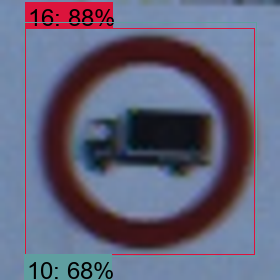

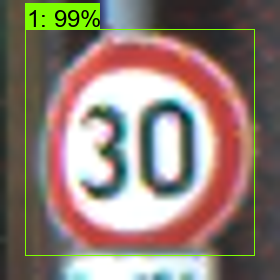

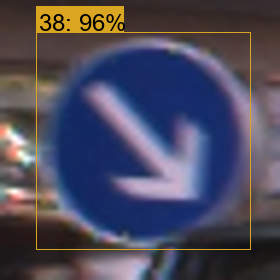

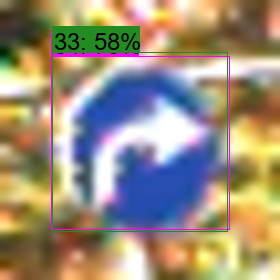

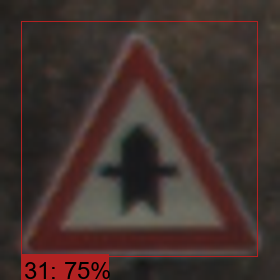

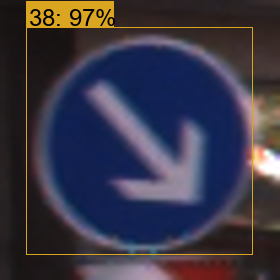

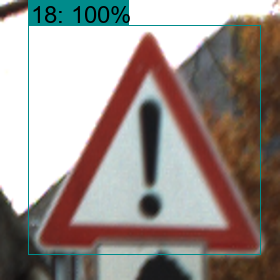

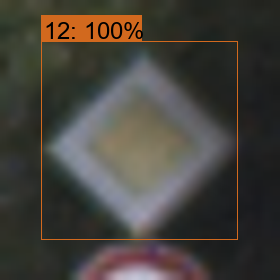

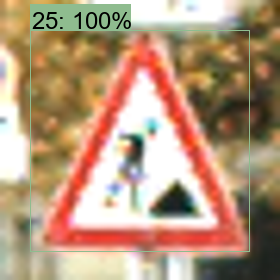

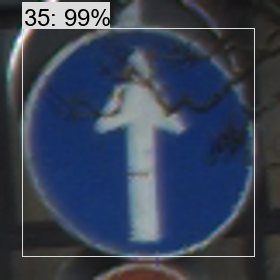

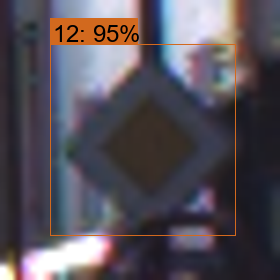

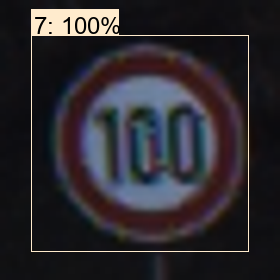

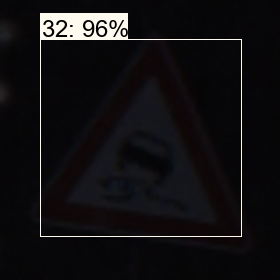

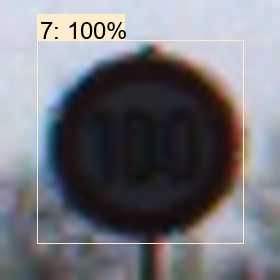

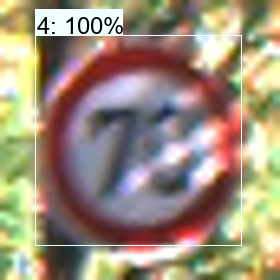

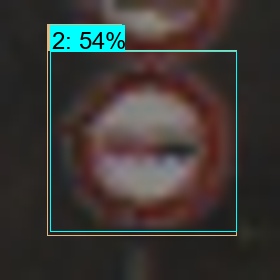

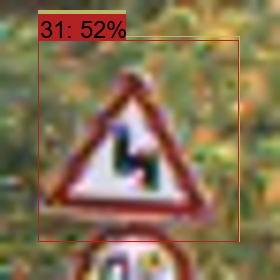

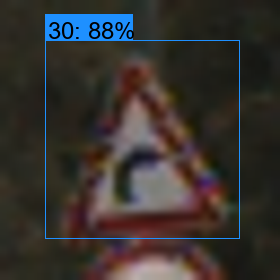

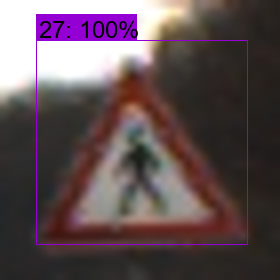

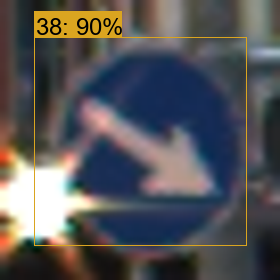

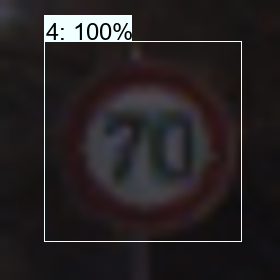

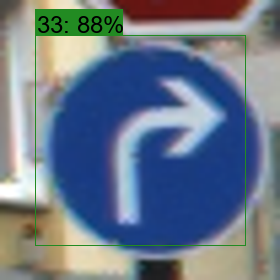

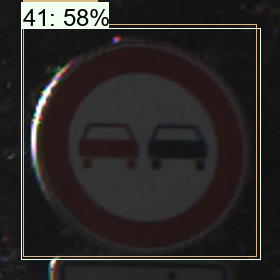

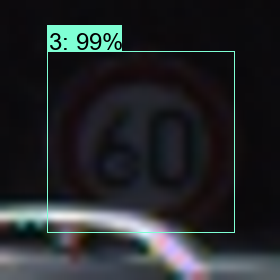

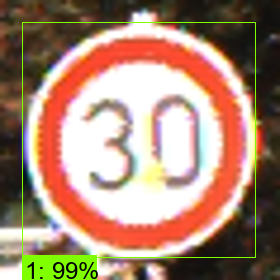

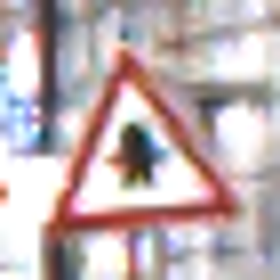

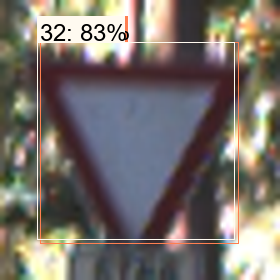

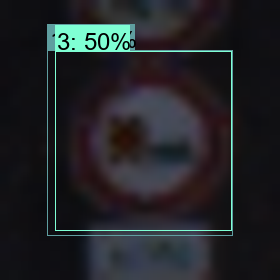

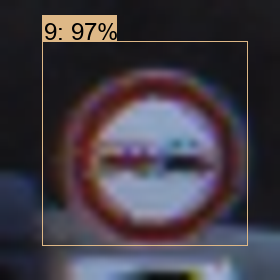

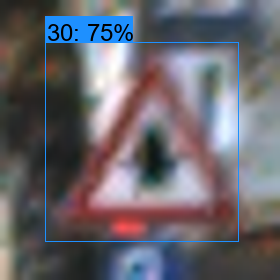

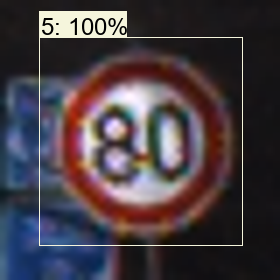

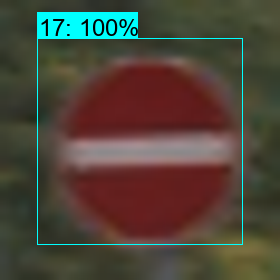

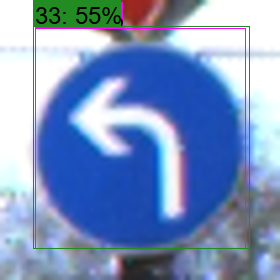

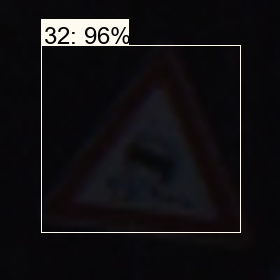

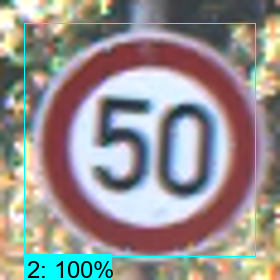

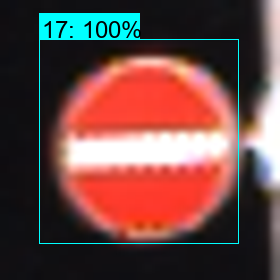

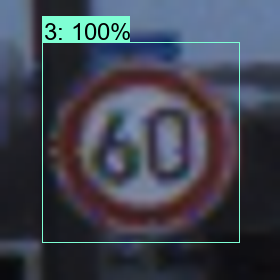

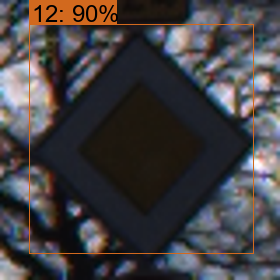

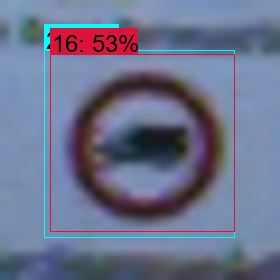

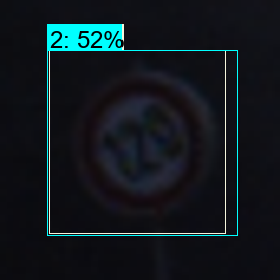

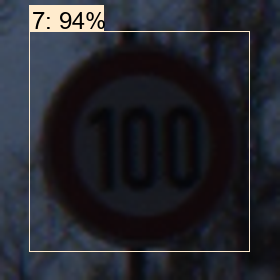

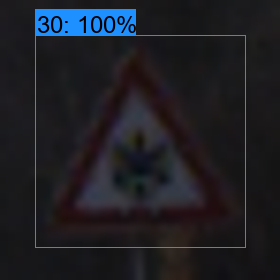

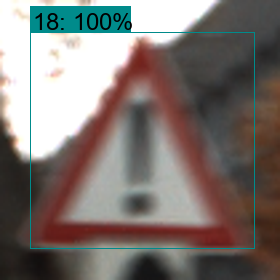

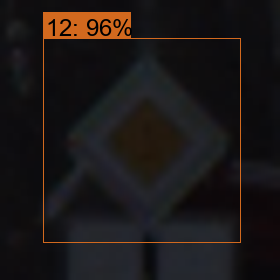

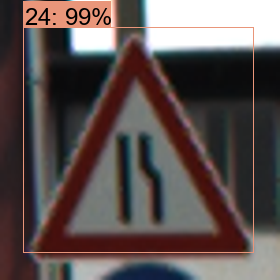

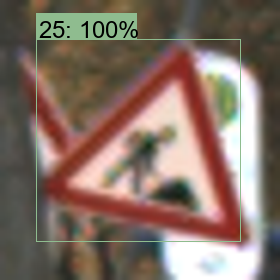

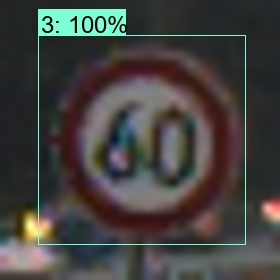

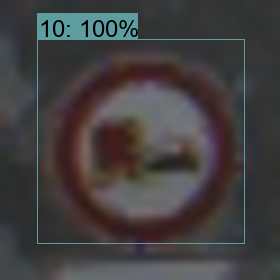

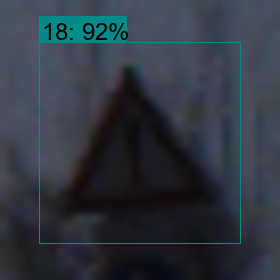

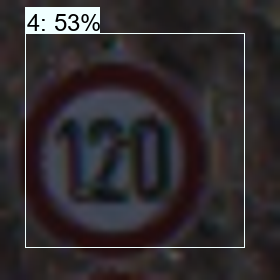

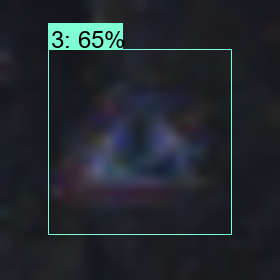

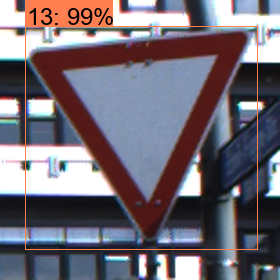

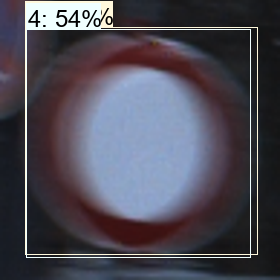

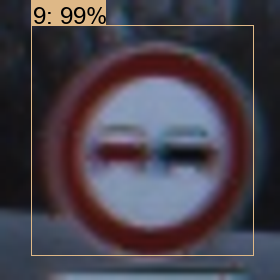

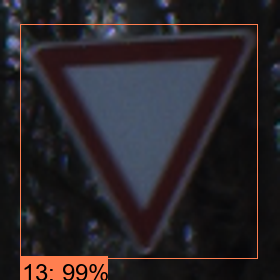

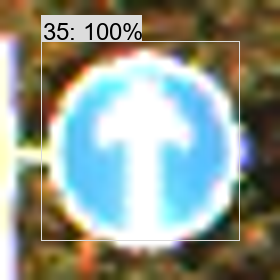

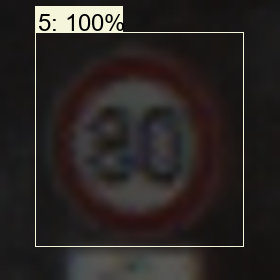

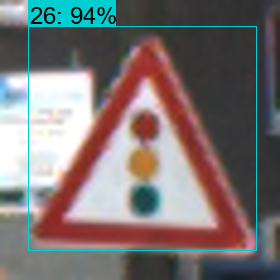

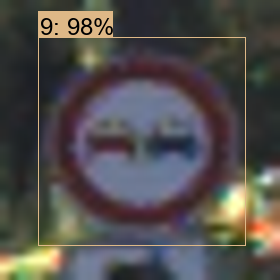

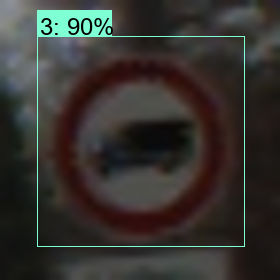

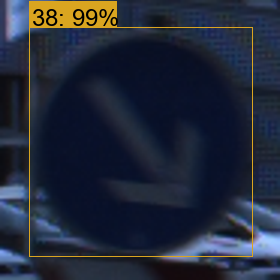

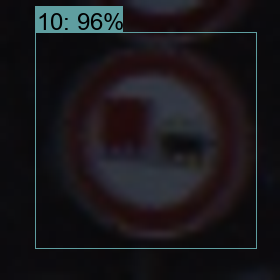

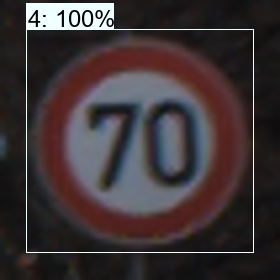

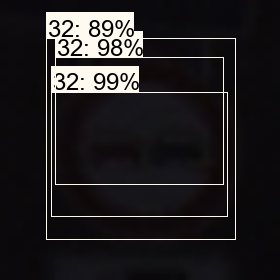

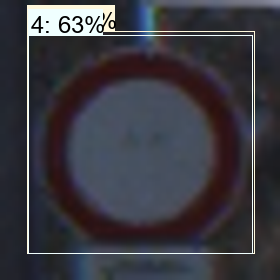

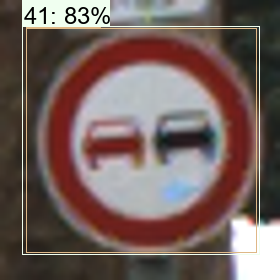

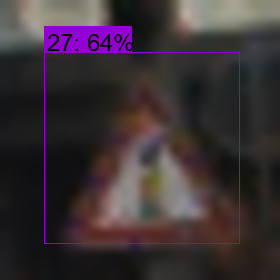

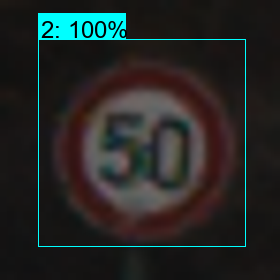

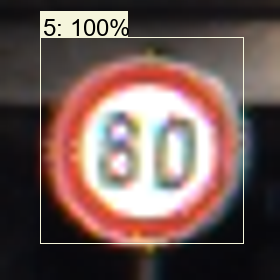

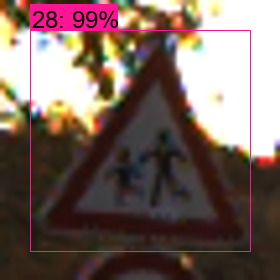

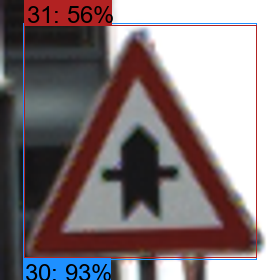

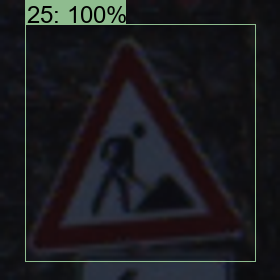

KeyboardInterrupt: 

In [21]:
for image_path in glob.glob('./GTSRB/Final_Test/Images/*.ppm'):
    image_np = load_image_into_numpy_array(image_path)
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=1)
    display(Image.fromarray(image_np))